In [8]:
from scipy.io import wavfile
import pandas as pd

frame_rate, sound_data = wavfile.read("data/flute_tone.wav")
sound_data = pd.DataFrame(sound_data, columns=["left", "right"])

In [9]:
import numpy as np
def fft(data, sampling_frequency):
    try:
        data = data.values
    except AttributeError:
        pass
    
    # Normalize Data
    data = data / (2.0**15)
    
    # Calculate FFT
    data_fft = np.fft.fft(data)
    data_angles = np.angle(data_fft)
    data_spec = np.abs(data_fft)
    
    # Calculate last frequency before Nyquist limit
    N = len(data)    
    data_samples_before_nyquist = np.ceil((N+1)/2.0)
    data_fft = data_fft[0:int(data_samples_before_nyquist)]
    
    # Normalize Spectrum
    data_fft = data_fft / float(N)
    
    # Calculate output values
    spec = np.abs(data_fft)
    power_spec = 20 * np.log10(spec)
    angle = np.angle(data_fft)    
    frequencies = np.arange(0, data_samples_before_nyquist) * (1.0 * sampling_frequency / N)
    
    return pd.DataFrame(np.transpose([frequencies, spec, power_spec, angle]), columns=["Frequency", "FFT", "FFT_Power", "Angle"])

In [10]:
fft_left = fft(sound_data["left"], frame_rate)
fft_right = fft(sound_data["right"], frame_rate)


In [11]:
import numpy as np
from math import pi, log

def _datacheck_peakdetect(x_axis, y_axis):
    if x_axis is None:
        x_axis = range(len(y_axis))
    
    if len(y_axis) != len(x_axis):
        raise (ValueError, 
                'Input vectors y_axis and x_axis must have same length')
    
    #needs to be a numpy array
    y_axis = np.array(y_axis)
    x_axis = np.array(x_axis)
    return x_axis, y_axis
    
def peakdetect(y_axis, x_axis = None, lookahead = 300, delta=0):
    """
    Converted from/based on a MATLAB script at: 
    http://billauer.co.il/peakdet.html
    
    function for detecting local maximas and minmias in a signal.
    Discovers peaks by searching for values which are surrounded by lower
    or larger values for maximas and minimas respectively
    
    keyword arguments:
    y_axis -- A list containg the signal over which to find peaks
    x_axis -- (optional) A x-axis whose values correspond to the y_axis list
        and is used in the return to specify the postion of the peaks. If
        omitted an index of the y_axis is used. (default: None)
    lookahead -- (optional) distance to look ahead from a peak candidate to
        determine if it is the actual peak (default: 200) 
        '(sample / period) / f' where '4 >= f >= 1.25' might be a good value
    delta -- (optional) this specifies a minimum difference between a peak and
        the following points, before a peak may be considered a peak. Useful
        to hinder the function from picking up false peaks towards to end of
        the signal. To work well delta should be set to delta >= RMSnoise * 5.
        (default: 0)
            delta function causes a 20% decrease in speed, when omitted
            Correctly used it can double the speed of the function
    
    return -- two lists [max_peaks, min_peaks] containing the positive and
        negative peaks respectively. Each cell of the lists contains a tupple
        of: (position, peak_value) 
        to get the average peak value do: np.mean(max_peaks, 0)[1] on the
        results to unpack one of the lists into x, y coordinates do: 
        x, y = zip(*tab)
    """
    max_peaks = []
    min_peaks = []
    dump = []   #Used to pop the first hit which almost always is false
       
    # check input data
    x_axis, y_axis = _datacheck_peakdetect(x_axis, y_axis)
    # store data length for later use
    length = len(y_axis)
    
    
    #perform some checks
    if lookahead < 1:
        raise ValueError, "Lookahead must be '1' or above in value"
    if not (np.isscalar(delta) and delta >= 0):
        raise ValueError, "delta must be a positive number"
    
    #maxima and minima candidates are temporarily stored in
    #mx and mn respectively
    mn, mx = np.Inf, -np.Inf
    
    #Only detect peak if there is 'lookahead' amount of points after it
    for index, (x, y) in enumerate(zip(x_axis[:-lookahead], 
                                        y_axis[:-lookahead])):
        if y > mx:
            mx = y
            mxpos = x
        if y < mn:
            mn = y
            mnpos = x
        
        ####look for max####
        if y < mx-delta and mx != np.Inf:
            #Maxima peak candidate found
            #look ahead in signal to ensure that this is a peak and not jitter
            if y_axis[index:index+lookahead].max() < mx:
                max_peaks.append([mxpos, mx])
                dump.append(True)
                #set algorithm to only find minima now
                mx = np.Inf
                mn = np.Inf
                if index+lookahead >= length:
                    #end is within lookahead no more peaks can be found
                    break
                continue
            #else:  #slows shit down this does
            #    mx = ahead
            #    mxpos = x_axis[np.where(y_axis[index:index+lookahead]==mx)]
        
        ####look for min####
        if y > mn+delta and mn != -np.Inf:
            #Minima peak candidate found 
            #look ahead in signal to ensure that this is a peak and not jitter
            if y_axis[index:index+lookahead].min() > mn:
                min_peaks.append([mnpos, mn])
                dump.append(False)
                #set algorithm to only find maxima now
                mn = -np.Inf
                mx = -np.Inf
                if index+lookahead >= length:
                    #end is within lookahead no more peaks can be found
                    break
            #else:  #slows shit down this does
            #    mn = ahead
            #    mnpos = x_axis[np.where(y_axis[index:index+lookahead]==mn)]
    
    
    #Remove the false hit on the first value of the y_axis
    try:
        if dump[0]:
            max_peaks.pop(0)
        else:
            min_peaks.pop(0)
        del dump
    except IndexError:
        #no peaks were found, should the function return empty lists?
        pass
        

    return [max_peaks, min_peaks]

peaks = np.array(peakdetect(fft_left.FFT_Power, fft_left.Frequency, lookahead=400, delta=10)[0])

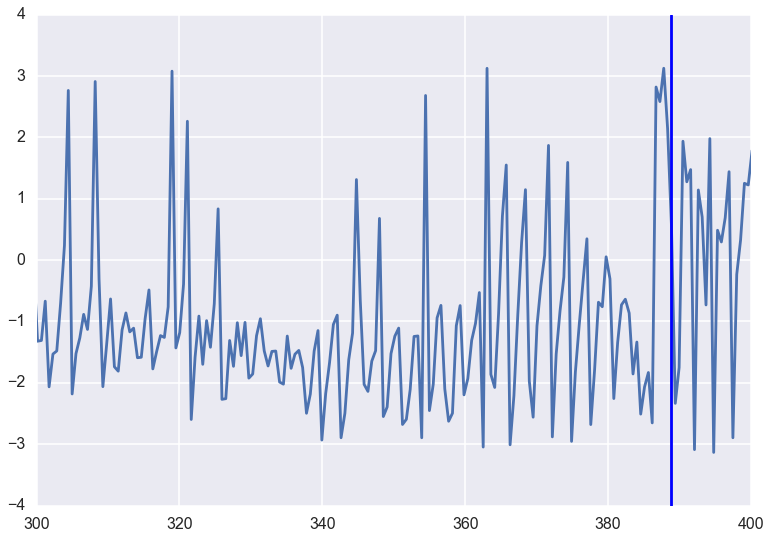

In [16]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sb
sb.set_context("poster")

plt.plot(fft_left.Frequency, fft_left.Angle)
#plt.scatter(*np.transpose(peaks), color="black", s=100)

plt.xlim(300, 400)
g_tone = 388.8756083
for i in xrange(1, 15):
    plt.gca().axvline(i * g_tone)

In [31]:
from time import sleep
s.start()
sleep(1)
s.stop()

In [30]:
for i, peak in enumerate(peaks[:10]):
    sines[i].freq = float(peak[0])
    sines[i].mul = float(10e29 * 10**float(peak[1]))
    print 10e29 * 10**float(peak[1])

0.13466681828
1.66936870387e-09
8.78985165382e-09
6.97977212431e-21
8.2647191263e-26
5.17592462629e-26
2.98927907214e-39
1.57091679284e-50
5.51680753815e-62
3.34113842994e-64
